In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys
from tqdm import tqdm
import tensorflow as tf
import edward as ed
from edward.models import Normal, Categorical
from subprocess import check_output
import matplotlib.pyplot as plt

ed.set_seed(12)
%matplotlib inline

In [2]:
data = pd.read_csv('mushrooms.csv')
data.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [3]:
data.shape

(8124, 23)

In [4]:
data2 = pd.get_dummies(data)
data2.shape

(8124, 119)

In [5]:
data_x = data2.loc[:, 'cap-shape_b':].as_matrix().astype(np.float32)
data_y = data2.loc[:, :'class_p'].as_matrix().astype(np.float32)

N = 7000
train_x, test_x = data_x[:N], data_x[N:]
train_y, test_y = data_y[:N], data_y[N:]

in_size = train_x.shape[1]
out_size = train_y.shape[1]


# for bayesian neural network
train_y2 = np.argmax(train_y, axis=1)
test_y2 = np.argmax(test_y, axis=1)

In [6]:
EPOCH_NUM = 20
BATCH_SIZE = 1000

In [7]:
#build a bnn
x_ = tf.placeholder(tf.float32, shape=(None, in_size))
y_ = tf.placeholder(tf.int32, shape=(BATCH_SIZE))

In [8]:
w = Normal(loc=tf.zeros([in_size, out_size]), scale=tf.ones([in_size, out_size]))
b = Normal(loc=tf.zeros([out_size]), scale=tf.ones([out_size]))
y_pre = Categorical(tf.matmul(x_, w) + b)

In [9]:
#posterior approximation
qw = Normal(loc=tf.Variable(tf.random_normal([in_size, out_size])), scale=tf.Variable(tf.random_normal([in_size, out_size])))
qb = Normal(loc=tf.Variable(tf.random_normal([out_size])), scale=tf.Variable(tf.random_normal([out_size])))

y = Categorical(tf.matmul(x_, qw) + qb)

In [10]:
inference = ed.KLqp({w: qw, b: qb}, data={y_pre: y_})
inference.initialize()

In [20]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [21]:
train_loss = np.zeros(EPOCH_NUM)

In [22]:
with sess:
    samples_num = 100
    for epoch in tqdm(range(EPOCH_NUM), file=sys.stdout):
        perm = np.random.permutation(N)
        for i in range(0, N, BATCH_SIZE):
            batch_x = train_x[perm[i:i+BATCH_SIZE]]
            batch_y = train_y2[perm[i:i+BATCH_SIZE]]
            info_dict = inference.update(feed_dict={x_: batch_x, y_: batch_y})
        train_loss[epoch] = info_dict['loss']
        y_samples = y.sample(samples_num).eval(feed_dict={x_: train_x})
        acc = (np.round(y_samples.sum(axis=0) / samples_num) == train_y2).mean()
        y_samples = y.sample(samples_num).eval(feed_dict={x_: test_x})
        test_acc = (np.round(y_samples.sum(axis=0) / samples_num) == test_y2).mean()
        if (epoch+1) % 10 == 0:
            tqdm.write('epoch:\t{}\taccuracy:\t{}\tvaridation accuracy:\t{}'.format(epoch+1, acc, test_acc))
sess.close()

epoch:	10	accuracy:	0.976285714286	varidation accuracy:	0.967081850534
epoch:	20	accuracy:	0.964714285714	varidation accuracy:	0.953736654804
epoch:	30	accuracy:	0.662285714286	varidation accuracy:	0.966192170819
epoch:	40	accuracy:	0.981857142857	varidation accuracy:	0.826512455516
100%|██████████| 40/40 [00:14<00:00,  2.09it/s]


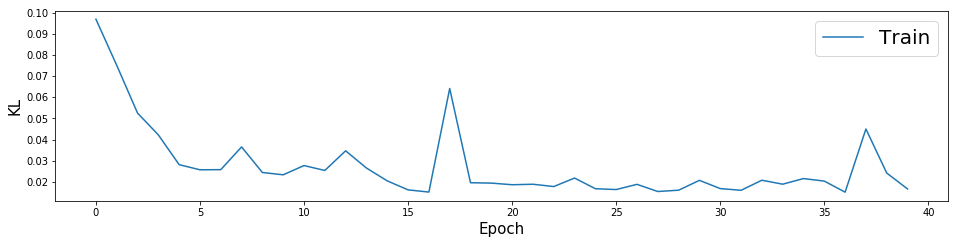

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 3.5))
plt.plot(np.arange(EPOCH_NUM), train_loss / len(train_x), label='Train')
plt.legend(fontsize=20)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('KL', fontsize=15)
plt.show()

# Using AdamOptimizer

In [36]:
inference = ed.KLqp({w: qw, b: qb}, data={y_pre: y_})
optimizer = tf.train.AdamOptimizer(5e-3)
inference.initialize(optimizer=optimizer, var_list=tf.trainable_variables())

In [37]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [38]:
train_loss2 = np.zeros(EPOCH_NUM)

In [39]:
with sess:
    samples_num = 100
    for epoch in tqdm(range(EPOCH_NUM), file=sys.stdout):
        perm = np.random.permutation(N)
        for i in range(0, N, BATCH_SIZE):
            batch_x = train_x[perm[i:i+BATCH_SIZE]]
            batch_y = train_y2[perm[i:i+BATCH_SIZE]]
            info_dict = inference.update(feed_dict={x_: batch_x, y_: batch_y})
        train_loss2[epoch] = info_dict['loss']
        y_samples = y.sample(samples_num).eval(feed_dict={x_: train_x})
        acc = (np.round(y_samples.sum(axis=0) / samples_num) == train_y2).mean()
        y_samples = y.sample(samples_num).eval(feed_dict={x_: test_x})
        test_acc = (np.round(y_samples.sum(axis=0) / samples_num) == test_y2).mean()
        if (epoch+1) % 10 == 0:
            tqdm.write('epoch:\t{}\taccuracy:\t{}\tvaridation accuracy:\t{}'.format(epoch+1, acc, test_acc))
sess.close()

epoch:	1	accuracy:	0.542	varidation accuracy:	0.560498220641
epoch:	2	accuracy:	0.682428571429	varidation accuracy:	0.451067615658
epoch:	3	accuracy:	0.649	varidation accuracy:	0.424377224199
epoch:	4	accuracy:	0.820285714286	varidation accuracy:	0.42615658363
epoch:	5	accuracy:	0.720428571429	varidation accuracy:	0.879893238434
epoch:	6	accuracy:	0.643857142857	varidation accuracy:	0.457295373665
epoch:	7	accuracy:	0.612142857143	varidation accuracy:	0.846975088968
epoch:	8	accuracy:	0.685571428571	varidation accuracy:	0.698398576512
epoch:	9	accuracy:	0.833428571429	varidation accuracy:	0.612099644128
epoch:	10	accuracy:	0.795142857143	varidation accuracy:	0.863879003559
epoch:	11	accuracy:	0.852571428571	varidation accuracy:	0.517793594306
epoch:	12	accuracy:	0.532142857143	varidation accuracy:	0.664590747331
epoch:	13	accuracy:	0.721142857143	varidation accuracy:	0.887010676157
epoch:	14	accuracy:	0.609571428571	varidation accuracy:	0.687722419929
epoch:	15	accuracy:	0.564285714286

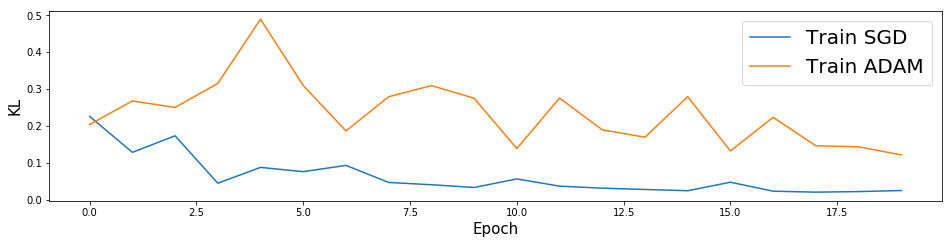

In [40]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 3.5))
plt.plot(np.arange(EPOCH_NUM), train_loss / len(train_x), label='Train SGD')
plt.plot(np.arange(EPOCH_NUM), train_loss2 / len(train_x), label='Train ADAM')
plt.legend(fontsize=20)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('KL', fontsize=15)
plt.show()

# Compare Mini Batch Size

In [24]:
EPOCH_NUM = 40
#batch sizes
small_batch = N/10
mid_batch = N/7
big_batch = N/5
#initialize losses
train_losssb = np.zeros(EPOCH_NUM)
train_lossmb = np.zeros(EPOCH_NUM)
train_lossbb = np.zeros(EPOCH_NUM)

with sess:
    batch_x = train_x[0:BATCH_SIZE]
    batch_y = train_y2[0:BATCH_SIZE]
    info_dict = inference.update(feed_dict={x_: batch_x, y_: batch_y})
    train_losssb[0] = info_dict['loss']
    train_lossmb[0] = info_dict['loss']
    train_lossbb[0] = info_dict['loss']

In [25]:
BATCH_SIZE = small_batch
#build a bnn
x_ = tf.placeholder(tf.float32, shape=(None, in_size))
y_ = tf.placeholder(tf.int32, shape=(BATCH_SIZE))
w = Normal(loc=tf.zeros([in_size, out_size]), scale=tf.ones([in_size, out_size]))
b = Normal(loc=tf.zeros([out_size]), scale=tf.ones([out_size]))
y_pre = Categorical(tf.matmul(x_, w) + b)
qw = Normal(loc=tf.Variable(tf.random_normal([in_size, out_size])), scale=tf.Variable(tf.random_normal([in_size, out_size])))
qb = Normal(loc=tf.Variable(tf.random_normal([out_size])), scale=tf.Variable(tf.random_normal([out_size])))

y = Categorical(tf.matmul(x_, qw) + qb)
inference = ed.KLqp({w: qw, b: qb}, data={y_pre: y_})
inference.initialize()
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [26]:
with sess:
    samples_num = 100
    for epoch in tqdm(range(EPOCH_NUM), file=sys.stdout):
        perm = np.random.permutation(N)
        for i in range(0, N, BATCH_SIZE):
            batch_x = train_x[perm[i:i+BATCH_SIZE]]
            batch_y = train_y2[perm[i:i+BATCH_SIZE]]
            info_dict = inference.update(feed_dict={x_: batch_x, y_: batch_y})
        train_losssb[epoch] = info_dict['loss']
        y_samples = y.sample(samples_num).eval(feed_dict={x_: train_x})
        acc = (np.round(y_samples.sum(axis=0) / samples_num) == train_y2).mean()
        y_samples = y.sample(samples_num).eval(feed_dict={x_: test_x})
        test_acc = (np.round(y_samples.sum(axis=0) / samples_num) == test_y2).mean()
        if (epoch+1) % 10 == 0:
            tqdm.write('epoch:\t{}\taccuracy:\t{}\tvaridation accuracy:\t{}'.format(epoch+1, acc, test_acc))
sess.close()

epoch:	10	accuracy:	0.938142857143	varidation accuracy:	0.966192170819
epoch:	20	accuracy:	0.961428571429	varidation accuracy:	0.761565836299
epoch:	30	accuracy:	0.929	varidation accuracy:	0.943060498221
epoch:	40	accuracy:	0.985142857143	varidation accuracy:	0.968861209964
100%|██████████| 40/40 [00:25<00:00,  1.41it/s]


In [27]:
BATCH_SIZE = mid_batch
#build a bnn
x_ = tf.placeholder(tf.float32, shape=(None, in_size))
y_ = tf.placeholder(tf.int32, shape=(BATCH_SIZE))
w = Normal(loc=tf.zeros([in_size, out_size]), scale=tf.ones([in_size, out_size]))
b = Normal(loc=tf.zeros([out_size]), scale=tf.ones([out_size]))
y_pre = Categorical(tf.matmul(x_, w) + b)
qw = Normal(loc=tf.Variable(tf.random_normal([in_size, out_size])), scale=tf.Variable(tf.random_normal([in_size, out_size])))
qb = Normal(loc=tf.Variable(tf.random_normal([out_size])), scale=tf.Variable(tf.random_normal([out_size])))

y = Categorical(tf.matmul(x_, qw) + qb)
inference = ed.KLqp({w: qw, b: qb}, data={y_pre: y_})
inference.initialize()
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [28]:
with sess:
    samples_num = 100
    for epoch in tqdm(range(EPOCH_NUM), file=sys.stdout):
        perm = np.random.permutation(N)
        for i in range(0, N, BATCH_SIZE):
            batch_x = train_x[perm[i:i+BATCH_SIZE]]
            batch_y = train_y2[perm[i:i+BATCH_SIZE]]
            info_dict = inference.update(feed_dict={x_: batch_x, y_: batch_y})
        train_lossmb[epoch] = info_dict['loss']
        y_samples = y.sample(samples_num).eval(feed_dict={x_: train_x})
        acc = (np.round(y_samples.sum(axis=0) / samples_num) == train_y2).mean()
        y_samples = y.sample(samples_num).eval(feed_dict={x_: test_x})
        test_acc = (np.round(y_samples.sum(axis=0) / samples_num) == test_y2).mean()
        if (epoch+1) % 10 == 0:
            tqdm.write('epoch:\t{}\taccuracy:\t{}\tvaridation accuracy:\t{}'.format(epoch+1, acc, test_acc))
sess.close()

epoch:	10	accuracy:	0.981	varidation accuracy:	0.961743772242
epoch:	20	accuracy:	0.972857142857	varidation accuracy:	0.955516014235
epoch:	30	accuracy:	0.943142857143	varidation accuracy:	0.865658362989
epoch:	40	accuracy:	0.951	varidation accuracy:	0.820284697509
100%|██████████| 40/40 [00:36<00:00,  1.02it/s]


In [29]:
BATCH_SIZE = big_batch
#build a bnn
x_ = tf.placeholder(tf.float32, shape=(None, in_size))
y_ = tf.placeholder(tf.int32, shape=(BATCH_SIZE))
w = Normal(loc=tf.zeros([in_size, out_size]), scale=tf.ones([in_size, out_size]))
b = Normal(loc=tf.zeros([out_size]), scale=tf.ones([out_size]))
y_pre = Categorical(tf.matmul(x_, w) + b)
qw = Normal(loc=tf.Variable(tf.random_normal([in_size, out_size])), scale=tf.Variable(tf.random_normal([in_size, out_size])))
qb = Normal(loc=tf.Variable(tf.random_normal([out_size])), scale=tf.Variable(tf.random_normal([out_size])))

y = Categorical(tf.matmul(x_, qw) + qb)
inference = ed.KLqp({w: qw, b: qb}, data={y_pre: y_})
inference.initialize()
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [30]:
with sess:
    samples_num = 100
    for epoch in tqdm(range(EPOCH_NUM), file=sys.stdout):
        perm = np.random.permutation(N)
        for i in range(0, N, BATCH_SIZE):
            batch_x = train_x[perm[i:i+BATCH_SIZE]]
            batch_y = train_y2[perm[i:i+BATCH_SIZE]]
            info_dict = inference.update(feed_dict={x_: batch_x, y_: batch_y})
        train_lossbb[epoch] = info_dict['loss']
        y_samples = y.sample(samples_num).eval(feed_dict={x_: train_x})
        acc = (np.round(y_samples.sum(axis=0) / samples_num) == train_y2).mean()
        y_samples = y.sample(samples_num).eval(feed_dict={x_: test_x})
        test_acc = (np.round(y_samples.sum(axis=0) / samples_num) == test_y2).mean()
        if (epoch+1) % 10 == 0:
            tqdm.write('epoch:\t{}\taccuracy:\t{}\tvaridation accuracy:\t{}'.format(epoch+1, acc, test_acc))
sess.close()

epoch:	10	accuracy:	0.977428571429	varidation accuracy:	0.625444839858
epoch:	20	accuracy:	0.990571428571	varidation accuracy:	0.899466192171
epoch:	30	accuracy:	0.936428571429	varidation accuracy:	0.983985765125
epoch:	40	accuracy:	0.956571428571	varidation accuracy:	0.949288256228
100%|██████████| 40/40 [00:47<00:00,  1.26s/it]


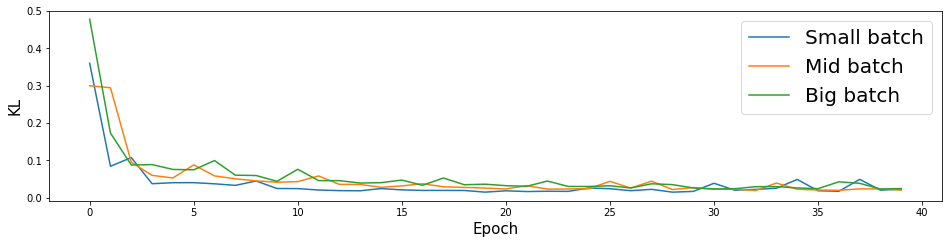

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 3.5))
plt.plot(np.arange(EPOCH_NUM), train_losssb / len(train_x), label='Small batch')
plt.plot(np.arange(EPOCH_NUM), train_lossmb / len(train_x), label='Mid batch')
plt.plot(np.arange(EPOCH_NUM), train_lossbb / len(train_x), label='Big batch')
plt.legend(fontsize=20)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('KL', fontsize=15)
plt.show()

# Using GradientDescentOptimizer

In [32]:
EPOCH_NUM = 40
#batch sizes
small_batch = N/10
mid_batch = N/7
big_batch = N/5
#initialize losses
train_losssb_sag = np.zeros(EPOCH_NUM)
train_lossmb_sag = np.zeros(EPOCH_NUM)
train_lossbb_sag = np.zeros(EPOCH_NUM)

with sess:
    batch_x = train_x[0:BATCH_SIZE]
    batch_y = train_y2[0:BATCH_SIZE]
    info_dict = inference.update(feed_dict={x_: batch_x, y_: batch_y})
    train_losssb[0] = info_dict['loss']
    train_lossmb[0] = info_dict['loss']
    train_lossbb[0] = info_dict['loss']

In [33]:
BATCH_SIZE = small_batch
#build a bnn
x_ = tf.placeholder(tf.float32, shape=(None, in_size))
y_ = tf.placeholder(tf.int32, shape=(BATCH_SIZE))
w = Normal(loc=tf.zeros([in_size, out_size]), scale=tf.ones([in_size, out_size]))
b = Normal(loc=tf.zeros([out_size]), scale=tf.ones([out_size]))
y_pre = Categorical(tf.matmul(x_, w) + b)
qw = Normal(loc=tf.Variable(tf.random_normal([in_size, out_size])), scale=tf.Variable(tf.random_normal([in_size, out_size])))
qb = Normal(loc=tf.Variable(tf.random_normal([out_size])), scale=tf.Variable(tf.random_normal([out_size])))

y = Categorical(tf.matmul(x_, qw) + qb)
inference = ed.KLqp({w: qw, b: qb}, data={y_pre: y_})
optimizer = tf.train.GradientDescentOptimizer(5e-3)
inference.initialize(optimizer=optimizer, var_list=tf.trainable_variables())
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [34]:
with sess:
    samples_num = 100
    for epoch in tqdm(range(EPOCH_NUM), file=sys.stdout):
        perm = np.random.permutation(N)
        for i in range(0, N, BATCH_SIZE):
            batch_x = train_x[perm[i:i+BATCH_SIZE]]
            batch_y = train_y2[perm[i:i+BATCH_SIZE]]
            info_dict = inference.update(feed_dict={x_: batch_x, y_: batch_y})
        train_losssb_sag[epoch] = info_dict['loss']
        y_samples = y.sample(samples_num).eval(feed_dict={x_: train_x})
        acc = (np.round(y_samples.sum(axis=0) / samples_num) == train_y2).mean()
        y_samples = y.sample(samples_num).eval(feed_dict={x_: test_x})
        test_acc = (np.round(y_samples.sum(axis=0) / samples_num) == test_y2).mean()
        if (epoch+1) % 10 == 0:
            tqdm.write('epoch:\t{}\taccuracy:\t{}\tvaridation accuracy:\t{}'.format(epoch+1, acc, test_acc))
sess.close()

epoch:	10	accuracy:	0.916285714286	varidation accuracy:	0.875444839858
epoch:	20	accuracy:	0.991428571429	varidation accuracy:	0.879893238434
epoch:	30	accuracy:	0.913	varidation accuracy:	0.973309608541
epoch:	40	accuracy:	0.974142857143	varidation accuracy:	0.902135231317
100%|██████████| 40/40 [00:56<00:00,  1.43s/it]


In [35]:
BATCH_SIZE = mid_batch
#build a bnn
x_ = tf.placeholder(tf.float32, shape=(None, in_size))
y_ = tf.placeholder(tf.int32, shape=(BATCH_SIZE))
w = Normal(loc=tf.zeros([in_size, out_size]), scale=tf.ones([in_size, out_size]))
b = Normal(loc=tf.zeros([out_size]), scale=tf.ones([out_size]))
y_pre = Categorical(tf.matmul(x_, w) + b)
qw = Normal(loc=tf.Variable(tf.random_normal([in_size, out_size])), scale=tf.Variable(tf.random_normal([in_size, out_size])))
qb = Normal(loc=tf.Variable(tf.random_normal([out_size])), scale=tf.Variable(tf.random_normal([out_size])))

y = Categorical(tf.matmul(x_, qw) + qb)
inference = ed.KLqp({w: qw, b: qb}, data={y_pre: y_})
inference.initialize()
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [36]:
with sess:
    samples_num = 100
    for epoch in tqdm(range(EPOCH_NUM), file=sys.stdout):
        perm = np.random.permutation(N)
        for i in range(0, N, BATCH_SIZE):
            batch_x = train_x[perm[i:i+BATCH_SIZE]]
            batch_y = train_y2[perm[i:i+BATCH_SIZE]]
            info_dict = inference.update(feed_dict={x_: batch_x, y_: batch_y})
        train_lossmb_sag[epoch] = info_dict['loss']
        y_samples = y.sample(samples_num).eval(feed_dict={x_: train_x})
        acc = (np.round(y_samples.sum(axis=0) / samples_num) == train_y2).mean()
        y_samples = y.sample(samples_num).eval(feed_dict={x_: test_x})
        test_acc = (np.round(y_samples.sum(axis=0) / samples_num) == test_y2).mean()
        if (epoch+1) % 10 == 0:
            tqdm.write('epoch:\t{}\taccuracy:\t{}\tvaridation accuracy:\t{}'.format(epoch+1, acc, test_acc))
sess.close()

epoch:	10	accuracy:	0.982428571429	varidation accuracy:	0.960854092527
epoch:	20	accuracy:	0.875571428571	varidation accuracy:	0.870106761566
epoch:	30	accuracy:	0.996714285714	varidation accuracy:	0.962633451957
epoch:	40	accuracy:	0.897285714286	varidation accuracy:	0.968861209964
100%|██████████| 40/40 [01:07<00:00,  1.81s/it]


In [37]:
BATCH_SIZE = big_batch
#build a bnn
x_ = tf.placeholder(tf.float32, shape=(None, in_size))
y_ = tf.placeholder(tf.int32, shape=(BATCH_SIZE))
w = Normal(loc=tf.zeros([in_size, out_size]), scale=tf.ones([in_size, out_size]))
b = Normal(loc=tf.zeros([out_size]), scale=tf.ones([out_size]))
y_pre = Categorical(tf.matmul(x_, w) + b)
qw = Normal(loc=tf.Variable(tf.random_normal([in_size, out_size])), scale=tf.Variable(tf.random_normal([in_size, out_size])))
qb = Normal(loc=tf.Variable(tf.random_normal([out_size])), scale=tf.Variable(tf.random_normal([out_size])))

y = Categorical(tf.matmul(x_, qw) + qb)
inference = ed.KLqp({w: qw, b: qb}, data={y_pre: y_})
inference.initialize()
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [38]:
with sess:
    samples_num = 100
    for epoch in tqdm(range(EPOCH_NUM), file=sys.stdout):
        perm = np.random.permutation(N)
        for i in range(0, N, BATCH_SIZE):
            batch_x = train_x[perm[i:i+BATCH_SIZE]]
            batch_y = train_y2[perm[i:i+BATCH_SIZE]]
            info_dict = inference.update(feed_dict={x_: batch_x, y_: batch_y})
        train_lossbb_sag[epoch] = info_dict['loss']
        y_samples = y.sample(samples_num).eval(feed_dict={x_: train_x})
        acc = (np.round(y_samples.sum(axis=0) / samples_num) == train_y2).mean()
        y_samples = y.sample(samples_num).eval(feed_dict={x_: test_x})
        test_acc = (np.round(y_samples.sum(axis=0) / samples_num) == test_y2).mean()
        if (epoch+1) % 10 == 0:
            tqdm.write('epoch:\t{}\taccuracy:\t{}\tvaridation accuracy:\t{}'.format(epoch+1, acc, test_acc))
sess.close()

epoch:	10	accuracy:	0.953142857143	varidation accuracy:	0.91103202847
epoch:	20	accuracy:	0.956571428571	varidation accuracy:	0.966192170819
epoch:	30	accuracy:	0.978	varidation accuracy:	0.862989323843
epoch:	40	accuracy:	0.993857142857	varidation accuracy:	0.903024911032
100%|██████████| 40/40 [01:19<00:00,  2.09s/it]


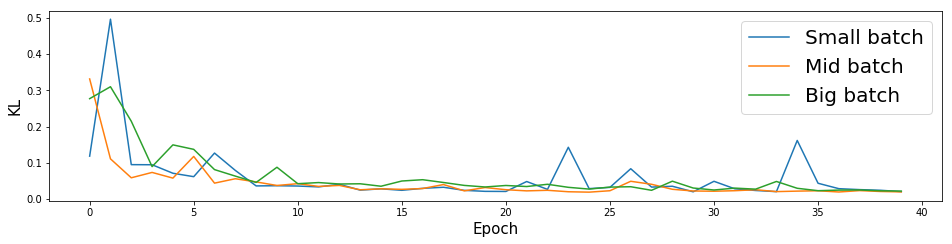

In [39]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 3.5))
plt.plot(np.arange(EPOCH_NUM), train_losssb_sag / len(train_x), label='Small batch')
plt.plot(np.arange(EPOCH_NUM), train_lossmb_sag / len(train_x), label='Mid batch')
plt.plot(np.arange(EPOCH_NUM), train_lossbb_sag / len(train_x), label='Big batch')
plt.legend(fontsize=20)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('KL', fontsize=15)
plt.show()